In [1]:
from utils import *
import torch

In [2]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'topo'
one_channel=False

X_train shape: 71138, (3, 24, 24)
Y_train shape: 71138, ()
X_val shape: 39641, (3, 24, 24)
Y_val shape: 39641, ()


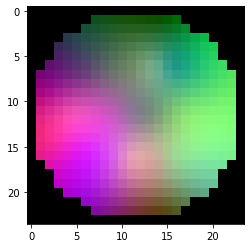

In [4]:
role = 'train'
train_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
plot_EEG(train_data, feature, numChan, one_channel)

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
model = create_model('vgg',feature)
print(model)
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 3, 24, 24)), show_input=False))

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [5]:
logger = Logger(mode='debug')
role = 'test'
test_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_test shape: {len(test_data)}, {test_data[0][0].shape}')
print(f'Y_test shape: {len(test_data)}, {test_data[0][1].shape}')
# model.load_state_dict(torch.load("saved-model/vgg-topo/model-vgg-topo-seed0-epoch20"))
# model.to(device=device)
# sample_acc, acc = test_model(model, test_data, 'data/test_subjIDs_fewer_subjects.csv', device, dtype, logger)
sample_acc, subject_acc = test_all_seeds("saved-model/vgg-topo/model-vgg-topo", 'vgg', feature, test_data, 'data/test_subjIDs_fewer_subjects.csv', 20, 2, device, dtype, logger)
# sample_acc, subject_acc = test_all_seeds("vgg-topo/model-vgg-topo", 20, False, logger)

X_test shape: 15925, (3, 24, 24)
Y_test shape: 15925, ()
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12056 / 15925 correct (75.70)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12177 / 15925 correct (76.46)
Testing model accuracy using 40-segment per subject metric
Got 159 / 197 correct (80.71)


In [12]:
def run_experiment(seed, model_name, feature, num_epoch):
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
    model = train(model, optimizer, epochs=num_epoch)
    
    # Testing
#     logger.log('Testing on balanced test set')
#     test_data_balanced = load_data(path, 'test', winLength, numChan, srate, feature,'v2')
#     sample_acc1, subject_acc1 = test_model(model, test_data_balanced, path + 'test_subjIDs.csv')

#     logger.log('Testing on all-male test set')
#     test_data_all_male = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
#     sample_acc2, subject_acc2 = test_model(model, test_data_all_male, path + 'test_subjIDs_more_test.csv')
    
    return model

In [ ]:
logger = Logger()
batch_size = 70 # original
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(10):
    model = run_experiment(s, 'vgg', 'topo', 70)

In [4]:
logger = Logger(mode='debug')
role = 'test'
test_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)

sample_acc, subject_acc = test_all_seeds("saved-model/vgg-topo/model-vgg-topo", 'vgg',feature,test_data,'data/test_subjIDs_fewer_subjects.csv',10, 10,device, dtype,logger)
min_sample = np.min(sample_acc)
max_sample = np.max(sample_acc)
mean_sample = np.mean(sample_acc)
std_sample = np.std(sample_acc)

min_subj = np.min(subject_acc)
max_subj = np.max(subject_acc)
mean_subj = np.mean(subject_acc)
std_subj = np.std(subject_acc)

logger.log("Per sample")
logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

logger.log("Per subject")
logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")


Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12384 / 15925 correct (77.76)
Testing model accuracy using 40-segment per subject metric
Got 157 / 197 correct (79.70)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12294 / 15925 correct (77.20)
Testing model accuracy using 40-segment per subject metric
Got 159 / 197 correct (80.71)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12269 / 15925 correct (77.04)
Testing model accuracy using 40-segment per subject metric
Got 154 / 197 correct (78.17)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12385 / 15925 correct (77.77)
Testing model accuracy using 40-segment per subject metric
Got 164 / 197 correct (83.25)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12289 / 15925 correct (77.17)
Testing model accuracy using 40-segment per subject metric
Got 162 / 197 correct (82.23)
Testi

In [12]:
logger = Logger(mode='debug')
epochs = [20, 30, 40, 50, 60, 69]

with open("vgg-topo-test-results-balanced.csv", 'w') as out:
    role = 'test'
    test_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
    print(f'X_test shape: {len(test_data)}, {test_data[0][0].shape}')
    print(f'Y_test shape: {len(test_data)}, {test_data[0][1].shape}')
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(model_name="vgg-topo/model-vgg-topo", epoch=epoch, isBalanced=True)

        min_sample, max_sample, mean_sample, std_sample = get_stats(sample_acc)
        min_subj, max_subj, mean_subj, std_subj = get_stats(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")

with open("vgg-topo-test-results-allmale.csv", 'w') as out:
    role = 'test'
    test_data = load_data(path, role, winLength, numChan, srate, feature, one_channel, 'all_male')
    print(f'X_test shape: {len(test_data)}, {test_data[0][0].shape}')
    print(f'Y_test shape: {len(test_data)}, {test_data[0][1].shape}')
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(model_name="vgg-topo/model-vgg-topo", epoch=epoch, isBalanced=False)

        min_sample = np.min(sample_acc)
        max_sample = np.max(sample_acc)
        mean_sample = np.mean(sample_acc)
        std_sample = np.std(sample_acc)

        min_subj = np.min(subject_acc)
        max_subj = np.max(subject_acc)
        mean_subj = np.mean(subject_acc)
        std_subj = np.std(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")
        

Testing on balanced test set
X_test shape: (15925, 3, 24, 24)
Y_test shape: (15925, 1)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12056 / 15925 correct (75.70)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12177 / 15925 correct (76.46)
Testing model accuracy using 40-segment per subject metric
Got 159 / 197 correct (80.71)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12004 / 15925 correct (75.38)
Testing model accuracy using 40-segment per subject metric
Got 155 / 197 correct (78.68)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12295 / 15925 correct (77.21)
Testing model accuracy using 40-segment per subject metric
Got 161 / 197 correct (81.73)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12238 / 15925 correct (76.85)
Testing

Got 12221 / 15925 correct (76.74)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12252 / 15925 correct (76.94)
Testing model accuracy using 40-segment per subject metric
Got 164 / 197 correct (83.25)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12245 / 15925 correct (76.89)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12245 / 15925 correct (76.89)
Testing model accuracy using 40-segment per subject metric
Got 162 / 197 correct (82.23)
Per sample
Min: 75.5353218210361, Max: 76.93563579277864, Mean: 76.51177394034536, STDEV: 0.4334015712852939
Per subject
Min: 80.20304568527918, Max: 83.24873096446701, Mean: 81.87817258883248, STDEV: 0.9644670050761456
Testing on balanced test set
X_test shape: (15925, 3, 24, 24

Got 556 / 649 correct (85.67)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 42552 / 53025 correct (80.25)
Testing model accuracy using 40-segment per subject metric
Got 571 / 649 correct (87.98)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 43813 / 53025 correct (82.63)
Testing model accuracy using 40-segment per subject metric
Got 582 / 649 correct (89.68)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 42127 / 53025 correct (79.45)
Testing model accuracy using 40-segment per subject metric
Got 577 / 649 correct (88.91)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 42825 / 53025 correct (80.76)
Testing model accuracy using 40-segment per subject metric
Got 572 / 649 correct (88.14)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 43535 / 53025 correct (82.10)
Testing model accuracy using 40-segment per subject metric
Got 5

Got 576 / 649 correct (88.75)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 42142 / 53025 correct (79.48)
Testing model accuracy using 40-segment per subject metric
Got 572 / 649 correct (88.14)
Per sample
Min: 75.82838283828383, Max: 82.45733144743046, Mean: 79.4977840641207, STDEV: 1.7934333585465811
Per subject
Min: 83.82126348228043, Max: 90.60092449922959, Mean: 87.91987673343604, STDEV: 1.9407145138778183
Testing on all male test set
X_test shape: (53025, 3, 24, 24)
Y_test shape: (53025, 1)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 42641 / 53025 correct (80.42)
Testing model accuracy using 40-segment per subject metric
Got 571 / 649 correct (87.98)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 41952 / 53025 correct (79.12)
Testing model accuracy using 40-segment per subject metric
Got 563 / 649 correct (86.75)
Got 590 / 649 correct (90.91)
Testing model accuracy using 1-segme